In [1]:
# python
import sys
import os
import importlib
import numpy as np
# columnar analysis
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea import processor
# local
sys.path.insert(1, os.path.join(sys.path[0], '../..')) # fixme: there must be a better way to handle this...
from sidm.tools import sidm_processor, utilities
# always reload local modules to pick up changes during development
importlib.reload(sidm_processor)
importlib.reload(utilities)
# plotting
import matplotlib.pyplot as plt
utilities.set_plot_style()
%matplotlib inline

In [2]:
samples = [
    '4mu_500GeV_5p0GeV_0p08mm',
    #'2mu2e_500GeV_5p0GeV_0p08mm',
]
fileset = utilities.make_fileset(samples, "llpNanoAOD_v2", max_files=1)
# create events collection from single file
fname = fileset[samples[0]][0]
print(fname)
events = NanoEventsFactory.from_root(
    fname,
    schemaclass=NanoAODSchema,
).events()

root://xcache//store/group/lpcmetx/SIDM/ULSignalSamples/2018_v6/LLPNanoAOD_V2/SIDM_BsTo2DpTo4Mu_MBs-500_MDp-5p0_ctau-0p08/LLPnanoAODv2/SIDM_BsTo2DpTo4Mu_MBs-500_MDp-5p0_ctau-0p08_part-0.root


In [3]:
#ak.fields(events)

In [4]:
#/store/group/lpcmetx/SIDM/ULSignalSamples/2018_v3/signals/SIDM_BsTo2DpTo4Mu_MBs-500_MDp-5p0_ctau-0p08/LLPnanoAOD/SIDM_BsTo2DpTo4Mu_MBs-500_MDp-5p0_ctau-0p08_part-0.rootak.fields(events.Muon)

In [5]:
print(events.PV.fields)
print(events.PV.pos.rho)
print(events.PV.x)
print(events.PV.y)
print(events.BS)
print(events.BS.fields)
print(events.BS.x)
print(events.BS.y)
print(utilities.rho(events.PV, ref=events.BS))
print(events.PV)
print(events.PV.npvs)
print(events.PV.ndof)
print(len(events.PV.z < 24))
print(len(events.Muon.pt > 100))
print(events.MET)
print(events.MET.fields)
print(ak.count([1, 2, 3], keepdims=False))
print(events.PV.ndim)
print(events.MET.ndim)
print(events.Muon.ndim)
print(ak.ones_like(events.MET.x, dtype=np.int32))
print(ak.unflatten(events.MET, ak.ones_like(events.MET.x, dtype=np.int32)))
print(events.MET.fields)
print(events.PV.fields)
print(events.genWeight.fields)
print(events.event.fields)

['ndof', 'x', 'y', 'z', 'chi2', 'score', 'npvs', 'npvsGood']
[2.66, 0.682, 3.2, 4.04, 0.969, 1.89, 0.113, ... 4.49, 2.73, 2.28, 5.54, 3.27, 0.761]
[0.0103, 0.00984, 0.0104, 0.0111, 0.0124, ... 0.0116, 0.00808, 0.0114, 0.00992]
[0.0429, 0.0394, 0.0403, 0.0379, 0.0407, ... 0.0429, 0.0403, 0.0394, 0.0403, 0.0428]
[[{x: 0.0108, y: 0.0419, z: 0.0249, ndof: 0, chi2: 0, ... chi2: 0, ntracks: 0}]]
['x', 'y', 'z', 'ndof', 'chi2', 'ntracks']
[[0.0108], [0.0108], [0.0108], [0.0108], ... [0.0108], [0.0108], [0.0108], [0.0108]]
[[0.0419], [0.0419], [0.0419], [0.0419], ... [0.0419], [0.0419], [0.0419], [0.0419]]
[[0.0011], [0.00269], [0.00162], [0.00398, ... [0.0037], [0.00168], [0.00126]]
[Vertex, Vertex, Vertex, Vertex, Vertex, ... Vertex, Vertex, Vertex, Vertex, Vertex]
[38, 34, 19, 28, 23, 23, 22, 14, 36, 7, ... 20, 40, 24, 53, 22, 22, 23, 39, 48, 14]
[99, 101, 105, 20.1, 114, 95.2, 18.8, 20.2, ... 111, 51, 166, 90.2, 30.4, 115, 116]
2004
2004
[MissingET, MissingET, MissingET, MissingET, ... Mis

In [6]:
print(events.GenPart.fields)
print(events.GenPart.pdgId)
print(ak.num(events.GenPart[abs(events.GenPart.pdgId)==13]))
genAs = events.GenPart[abs(events.GenPart.pdgId)==32]
print(ak.num(genAs))
print(genAs.children.pdgId)
print(abs(events.GenPart.pdgId))
print(ak.all(abs(genAs.children.pdgId) == 13, axis=-1))
print((genAs - genAs.children[:, 0]).r)
genAs_toE = genAs[ak.all(abs(genAs.children.pdgId) == 11, axis=-1)]
genAs_toMu = genAs[ak.all(abs(genAs.children.pdgId) == 13, axis=-1)]
print(genAs_toMu)
print((genAs_toMu - genAs_toMu.children[:, 0]).r)
genAs_toE = genAs_toE[ak.num(genAs_toE) > 0]
print(genAs_toE)
print((genAs_toE - genAs_toE.children[:, 0]).r)

['eta', 'mass', 'phi', 'pt', 'genPartIdxMother', 'pdgId', 'status', 'statusFlags', 'vx', 'vy', 'vz', 'px', 'py', 'pz', 'genPartIdxMotherG', 'distinctParentIdxG', 'childrenIdxG', 'distinctChildrenIdxG', 'distinctChildrenDeepIdxG']
[[-4, 4, 35, 35, 32, 32, -13, 13, -13, ... -12, -11, 12, 11, -11, 11, -11, 11, -11]]
[4, 4, 6, 8, 6, 9, 4, 6, 4, 6, 6, 7, 5, 7, ... 4, 4, 4, 5, 5, 4, 6, 6, 4, 4, 7, 4, 4]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ... 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
[[[-13, 13], [-13, 13]], [[-13, 13], [-13, ... [-13, 13]], [[-13, 13], [-13, 13]]]
[[4, 4, 35, 35, 32, 32, 13, 13, 13, 13, ... 11, 12, 11, 12, 11, 11, 11, 11, 11, 11]]
[[True, True], [True, True], [True, True, ... True], [True, True], [True, True]]
[[74.5, 318], [185, 431], [218, 475], ... [41, 241], [275, 442], [20.8, 179]]
[[GenParticle, GenParticle], [GenParticle, ... [GenParticle, GenParticle]]
[[74.5, 318], [185, 431], [218, 475], ... [41, 241], [275, 442], [20.8, 179]]
[]
[]


In [7]:
#events.Electron.fields

In [8]:
events[ak.num(events.Electron)>0].Electron.vidNestedWPBitmap

<Array [[613550372], ... [612516900]] type='290 * var * int32[parameters={"__doc...'>

In [9]:
#events.DSAMuon.fields

In [10]:
print(events.DSAMuon.muonMatch1)
print(events.DSAMuon.nSegments)
print(ak.num(events.DSAMuon))
print(ak.num(events.DSAMuon[events.DSAMuon.muonMatch1/events.DSAMuon.nSegments < 0.667]))

[[2, 3, 2], [6, 5, 0, 7, 0, 1], [3, 0, 0, ... 2], [3, 0, 3, 4, 2], [3, 3, 2, 3, 4]]
[[2, 3, 2], [7, 5, 0, 7, 1, 1], [3, 4, 1, ... 2], [3, 4, 3, 4, 3], [3, 3, 2, 3, 4]]
[3, 6, 6, 6, 8, 4, 3, 2, 3, 4, 6, 4, 5, 4, ... 3, 4, 4, 4, 5, 3, 8, 4, 3, 5, 5, 5, 5]
[0, 1, 2, 1, 2, 0, 0, 1, 0, 0, 2, 0, 1, 0, ... 0, 0, 0, 0, 2, 0, 3, 0, 1, 1, 1, 2, 0]


/opt/conda/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(


In [11]:
#print(events.DSAMuon.muonMatch1[0])
print(set(ak.flatten(events.DSAMuon.muonMatch1idx)))
print(events.DSAMuon[0])
print(events.Muon[0])
print(events.Muon[ak.values_astype(events.DSAMuon.muonMatch1idx, "int64")])
a = ak.Array([[0, 1, 0], [1]])
b = ak.Array([[71, 72], [59, 58, 57]])
b[a]

{0.0, 1.0, 2.0, 3.0, 4.0}
[{idx: 0, pt: 109, ptErr: 48.2, eta: 0.848, ... nDTSegments: 2, nCSCSegments: 0}]
[Muon, Muon, Muon, Muon]
[[Muon, Muon, Muon], [Muon, Muon, Muon, ... Muon], [Muon, Muon, Muon, Muon, Muon]]


<Array [[71, 72, 71], [58]] type='2 * var * int64'>

In [12]:
print(events.DSAMuon.muonMatch1)
print(events.DSAMuon.muonMatch1idx)
print(ak.flatten(events.DSAMuon.muonMatch1idx))
#print(events.DSAMuon.outerPhi)
print(events.Muon.outerPhi)
print(events.Muon[ak.values_astype(events.DSAMuon.muonMatch1idx, "int64")].outerPhi)
utilities.dR_outer(events.DSAMuon, events.Muon[ak.values_astype(events.DSAMuon.muonMatch1idx, "int64")])

[[2, 3, 2], [6, 5, 0, 7, 0, 1], [3, 0, 0, ... 2], [3, 0, 3, 4, 2], [3, 3, 2, 3, 4]]
[[0, 1, 3], [1, 4, 4, 0, 4, 3], [2, 3, 3, ... 2], [1, 3, 2, 0, 3], [0, 3, 3, 1, 2]]
[0, 1, 3, 1, 4, 4, 0, 4, 3, 2, 3, 3, 1, 0, ... 0, 1, 2, 1, 3, 2, 0, 3, 0, 3, 3, 1, 2]
[[0.181, -2.98, 0.172, -2.97], [1.3, -1.83, ... 1.92], [-0.29, 2.95, 3.08, 0.216]]
[[0.181, -2.98, -2.97], [-1.83, 1.47, 1.47, ... [-0.29, 0.216, 0.216, 2.95, 3.08]]


<Array [[0.000255, 0.000276, ... 0.0023]] type='2004 * var * float32'>

In [13]:
#from coffea.nanoevents.schemas.base import zip_forms
from coffea.nanoevents.methods import vector as cvec
from coffea.nanoevents.methods import nanoaod
#print(events.Muon)
#print([events.DSAMuon[x] for x in ["pt", "eta"]])
print(events.DSAMuon)
forms = {f : events.DSAMuon[f] for f in events.DSAMuon.fields}
events.DSAMuon = ak.zip(forms, with_name="Muon", behavior=nanoaod.behavior)
print(events.DSAMuon)
print(events.DSAMuon.nearest(events.Muon))

[[{idx: 0, pt: 109, ptErr: 48.2, eta: 0.848, ... nDTSegments: 4, nCSCSegments: 0}]]
[[Muon, Muon, Muon], [Muon, Muon, Muon, ... Muon], [Muon, Muon, Muon, Muon, Muon]]
[[Muon, Muon, Muon], [Muon, Muon, Muon, ... Muon], [Muon, Muon, Muon, Muon, Muon]]


In [14]:
#g = events.GenPart
#print(g)
#print(ak.count(g))
#print(ak.num(g, axis=1))
#print(ak.num(g, axis=0))
#print(ak.num(g.children, axis=2))
#g = g[ak.num(g.children, axis=2) > 0]
#print(g.children[ak.num(g.children, axis=2) > 0][:, :, 0])
#print(ak.count(ak.num(g.children, axis=2) > 0))
#print(g.children[:, :, 0])
#print((g - g.children[:, :, 0]))
#print(ak.num(g.children))
#print(ak.firsts(g.children))
#print(ak.num(ak.firsts(g.children)))
#print(~ak.is_none(ak.firsts(g.children)))
#print((g - g.children[:, :, 0]).r)
#print(g.pdgId)
#zd = g[g.pdgId == 32]
#ak.num(zd.children)
#print(zd)
#zd_lxy = (zd - ak.firsts(zd.children)).r
#print(zd_lxy)
#print(ak.num(zd_lxy, axis=1))
zd = events.GenPart[abs(events.GenPart.pdgId) == 32]
print(zd)
print(ak.num(zd))

[[GenParticle, GenParticle], [GenParticle, ... [GenParticle, GenParticle]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ... 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [15]:
runner = processor.Runner(
    executor=processor.IterativeExecutor(),
    #executor=processor.FuturesExecutor(),
    schema=NanoAODSchema,
    maxchunks=1,
)

channels = [
        #"llpnano",
        #"4mu",
        #"baseNoLj_A_mumu_matched_lj",
        "baseNoLj",
]
p = sidm_processor.SidmProcessor(
    channels,
    ["base_plus_gen"],
    #verbose=True,
)

output = runner.run(fileset, treename='Events', processor_instance=p)
out = output["out"]

Output()

Output()

Warning: zero genAs_toE objects found in this sample. Skipping.

Not applying any obj cuts after LJ clustering for channel baseNoLj

Not applying any obj cuts after lj clustering for channel  baseNoLj

/opt/conda/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in
divide
  result = getattr(ufunc, method)(

#--------------------------------------------------------------------------
#                         FastJet release 3.4.0
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


Warning: a histogram with the name genAs_toMu_pt_MuMudR_lowRange could not be filled and will be skipped

Warning: a histogram with the name genAs_toMu_pt_MuMudR_XLowRange could not be filled and will be skipped

Warning: a histogram with the name genAs_toMu_pt_MuMudR_XXLowRange could not be filled and will be skipped

Warning: a histogram with the name genAs_toMu_lxy_MuMudR could not be filled and will be skipped

Warning: a histogram with the name genAs_toMu_lxy_MuMudR_XLowRange could not be filled and will be skipped

Warning: a histogram with the name genAs_toMu_lxy_MuMudR_XXLowRange could not be filled and will be skipped

Warning: a histogram with the name genAs_toMu_pt_MuMudR_highRange could not be filled and will be skipped

Warning: a histogram with the name genAs_toMu_pt_highRange_MuMudR_lowRange could not be filled and will be skipped

Warning: a histogram with the name genAs_toE_n could not be filled and will be skipped

Warning: a histogram with the name genAs_toE_pt could not be filled and will be skipped

Warning: a histogram with the name genAs_toE_lxy could not be filled and will be skipped

Warning: a histogram with the name genAs_toE_lxy_lowRange could not be filled and will be skipped

Warning: a histogram with the name genAs_toE_lxy_midRange could not be filled and will be skipped

Warning: a histogram with the name genAs_toE_lxy_ecal could not be filled and will be skipped

Warning: a histogram with the name genAs_toE_pt_highRange could not be filled and will be skipped

Warning: a histogram with the name genAs_toE_eta could not be filled and will be skipped

Warning: a histogram with the name genAs_toE_pt_EEdR_lowRange could not be filled and will be skipped

Warning: a histogram with the name genAs_toE_pt_EEdR_XLowRange could not be filled and will be skipped

Warning: a histogram with the name genAs_toE_pt_EEdR_XXLowRange could not be filled and will be skipped

Warning: a histogram with the name genAs_toE_lxy_EEdR could not be filled and will be skipped

Warning: a histogram with the name genAs_toE_lxy_EEdR_XLowRange could not be filled and will be skipped

Warning: a histogram with the name genAs_toE_lxy_EEdR_XXLowRange could not be filled and will be skipped

Warning: a histogram with the name genAs_toE_lxy_pt_lowRange could not be filled and will be skipped

Warning: a histogram with the name genAs_toE_pt_lxy could not be filled and will be skipped

Warning: a histogram with the name genAs_toE_matched_egmLj_pt_lxy could not be filled and will be skipped

Warning: a histogram with the name genAs_toE_lj_dR could not be filled and will be skipped

Warning: a histogram with the name genAs_toE_matched_lj_lxy could not be filled and will be skipped

Warning: a histogram with the name genAs_toE_matched_egmLj_lxy could not be filled and will be skipped

Warning: a histogram with the name genAs_toE_matched_egmLj_lxy_lowRange could not be filled and will be skipped

Warning: a histogram with the name genAs_toE_matched_egmLj_lxy_midRange could not be filled and will be skipped

Warning: a histogram with the name genAs_toE_matched_egmLj_lxy_ecal could not be filled and will be skipped

Warning: a histogram with the name genAs_toE_matched_egmLj_pt could not be filled and will be skipped

Warning: a histogram with the name genAs_toE_matched_egmLj_pt_highRange could not be filled and will be skipped

Warning: a histogram with the name genAs_toE_matched_egmLj_eta could not be filled and will be skipped

Warning: a histogram with the name genAs_toE_matched_egmLj_n could not be filled and will be skipped

Warning: cannot fill counter Gen As to electrons. Skipping.

Warning: cannot fill counter Matched gen As to electrons. Skipping.

In [16]:
hists = out[samples[0]]["hists"]

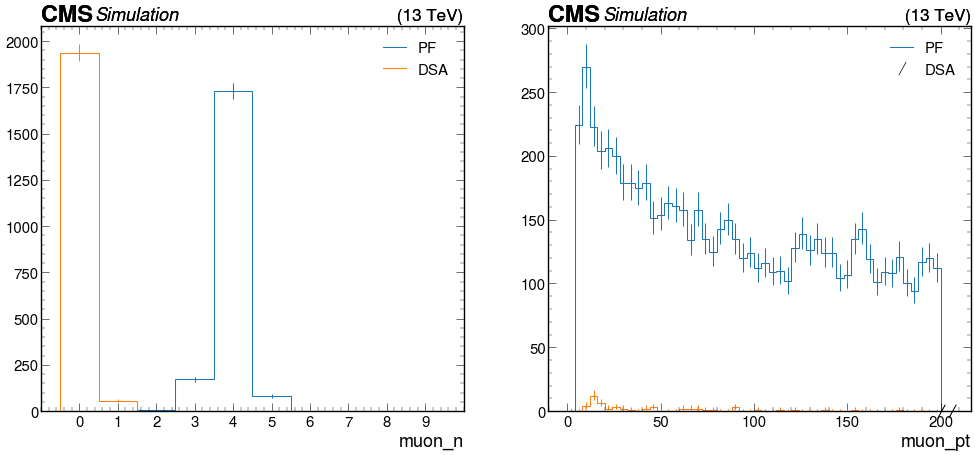

In [17]:
ch = channels[0]
plt.subplots(1, 2, figsize=(24, 10))
plt.subplot(1, 2, 1)
utilities.plot(hists["muon_n"][ch, :])
utilities.plot(hists["dsaMuon_n"][ch, :])
plt.legend(["PF", "DSA"])
plt.subplot(1, 2, 2)
utilities.plot(hists["muon_pt"][ch, ::2j])
utilities.plot(hists["dsaMuon_pt"][ch, ::2j])
plt.legend(["PF", "DSA"])

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f24dad0ff40>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

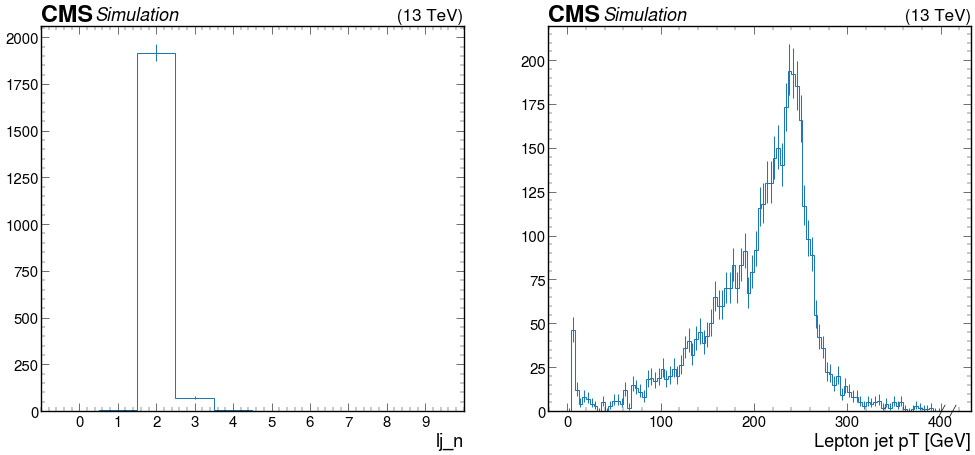

In [18]:
plt.subplots(1, 2, figsize=(24, 10))
plt.subplot(1, 2, 1)
utilities.plot(hists["lj_n"][ch, :])
plt.subplot(1, 2, 2)
utilities.plot(hists["lj_pt"][ch, :])

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f24da34e3a0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

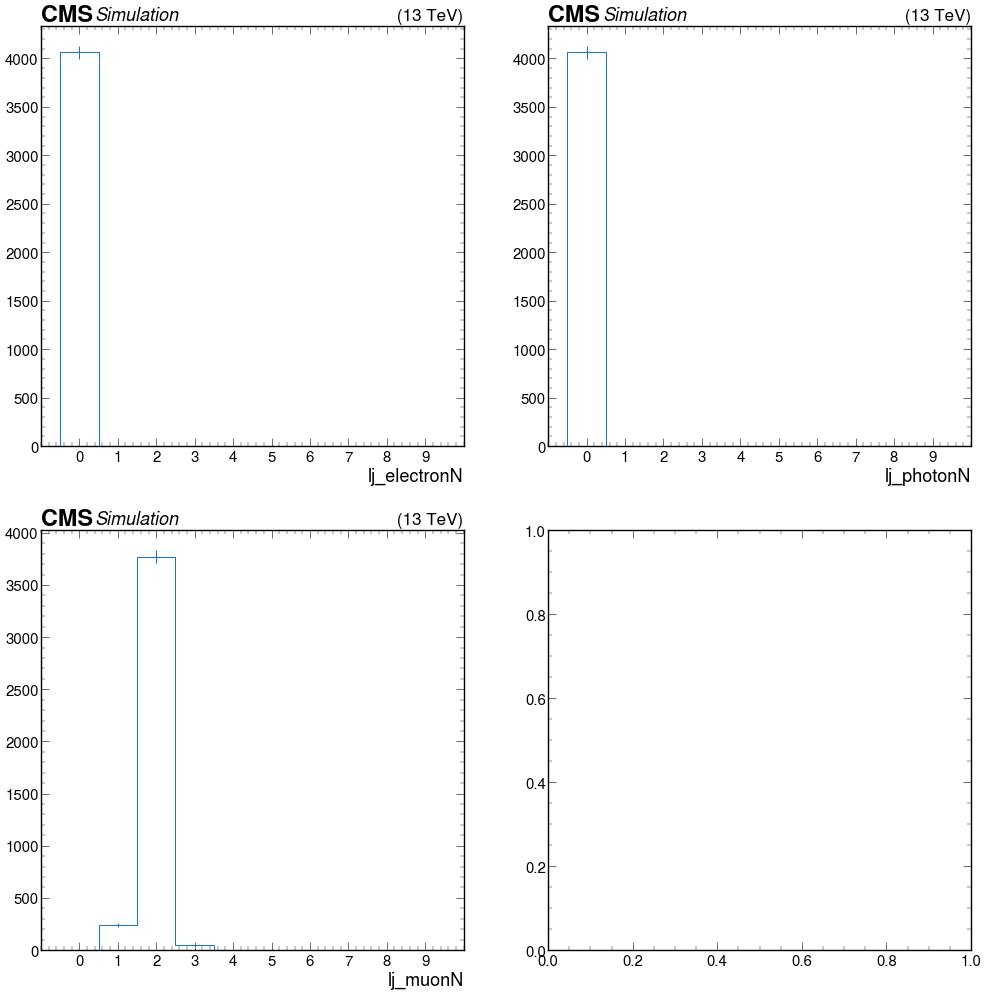

In [19]:
plt.subplots(2, 2, figsize=(24, 24))
plt.subplot(2, 2, 1)
utilities.plot(hists["lj_electronN"][ch, :])
plt.subplot(2, 2, 2)
utilities.plot(hists["lj_photonN"][ch, :])
plt.subplot(2, 2, 3)
utilities.plot(hists["lj_muonN"][ch, :])
#plt.subplot(2, 2, 4)
#utilities.plot(hists["lj_dsaMuonN"][ch, :])

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f25004a6220>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

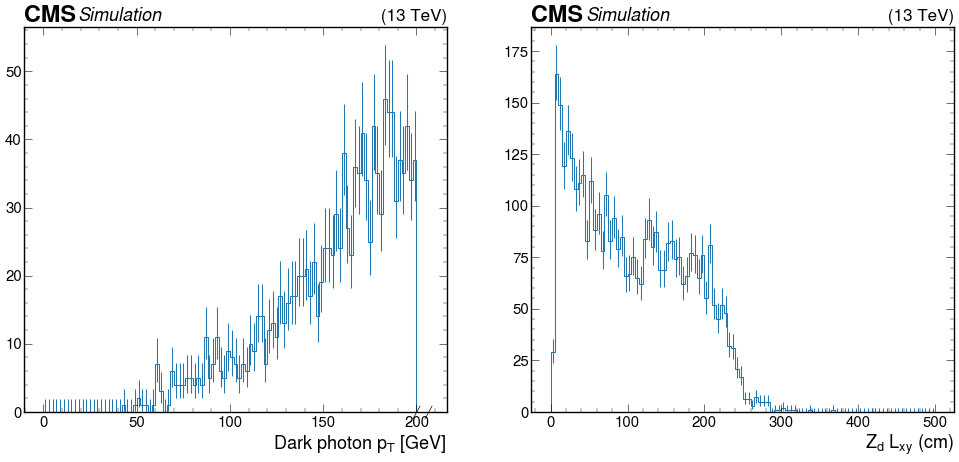

In [20]:
plt.subplots(1, 2, figsize=(24, 10))
plt.subplot(1, 2, 1)
utilities.plot(hists["genAs_pt"][ch, :])
plt.subplot(1, 2, 2)
utilities.plot(hists["genAs_lxy"][ch, :])

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f2500191430>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

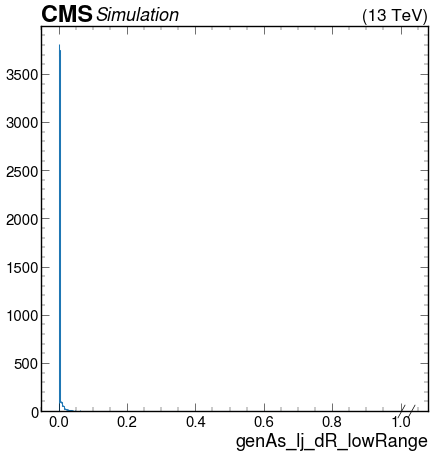

In [21]:
utilities.plot(hists["genAs_lj_dR_lowRange"][ch, :])